In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [3]:
class Metrop(object):
    def __init__(self, initial, pdf, proposal_pdf, proposal_generator):
        self.pdf = pdf
        self.proposal_pdf = proposal_pdf
        self.proposal_generator = proposal_generator
        self.state = initial
        
    def __call__(self, N=1):
        chain = np.empty(N)
        
        for i in range(N):
            proposal = self.proposal_generator(self.state)
            # hasting ratio
            r = self.pdf(proposal)*self.proposal_pdf(proposal, self.state)/self.pdf(self.state)/self.proposal_pdf(self.state, proposal)
            a = min(1, r)
            if a == 1 or np.random.rand() < a:
                self.state = chain[i] = proposal
            else:
                chain[i] = self.state
        return chain

In [4]:
def auto_cov(a):
    mean = np.mean(a)
    acov = np.empty(len(a))
    acov[0] = np.var(a)
    for k in range(1, len(a)):
        acov[k] = np.sum((a[:-k]-mean)*(a[k:]-mean)) / len(a)
    return acov

def auto_corr(a):
    acov = auto_cov(a)
    return acov / acov[0]

def plot_bins(acov):
    plt.bar(np.arange(len(acov)), acov)

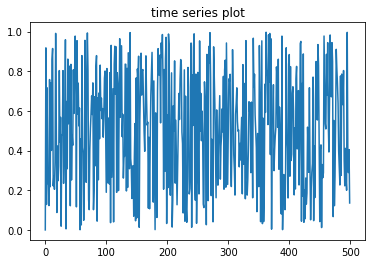

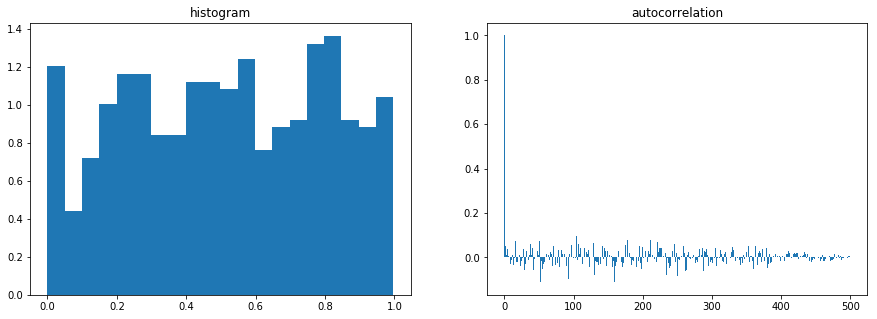

In [177]:
# example: uniform proposal and uniform pdf metropolis
metrop_uniform = Metrop(0, lambda x: 1, lambda x, y: 1, lambda x: np.random.rand())
r = metrop_uniform(500)

plt.title("time series plot")
plt.plot(r)
plt.show()

plt.figure(figsize=(15, 5))

# plot histogram
plt.subplot(121)
plt.title("histogram")
_ = plt.hist(r, bins=20, normed=True)

# plot autocorrelation
plt.subplot(122)
plt.title("autocorrelation")
acov = auto_corr(r)
plot_bins(acov)
plt.show()

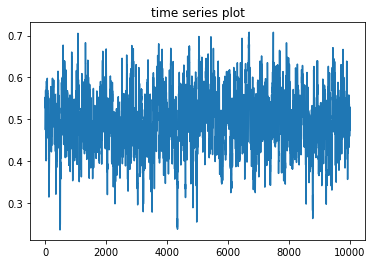

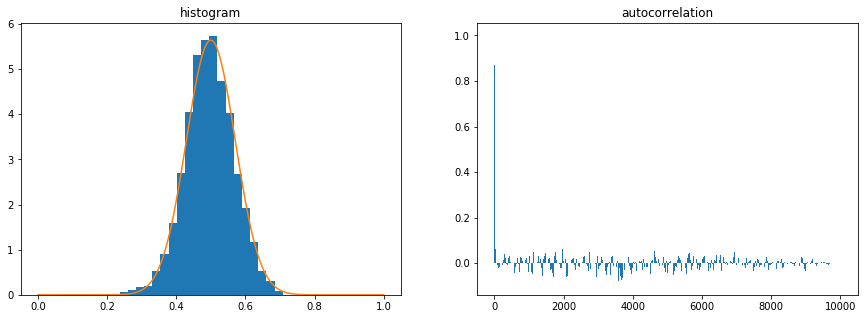

In [5]:
# example: local proposal and uniform pdf metropolis
delta = .1
proposal_generator = lambda s: min(max(0, s-delta/2), 1-delta) + np.random.rand()*delta
proposal_pdf = lambda x, y: 1/delta
pdf = lambda x: np.exp(-(x-.5)**2/.01)
metrop_gauss1 = Metrop(.5, pdf, proposal_pdf, proposal_generator)

r = metrop_gauss1(10000)[::1]
plt.title("time series plot")
plt.plot(r)
plt.show()

plt.figure(figsize=(15, 5))

# plot histogram
plt.subplot(121)
plt.title("histogram")
_ = plt.hist(r, bins=20, normed=True)
x = np.linspace(0, 1, 1000)
plt.plot(x, pdf(x)/integrate.quad(pdf, 0, 1)[0])

# plot autocorrelation
plt.subplot(122)
plt.title("autocorrelation")
acov = auto_corr(r)
plot_bins(acov)
plt.show()

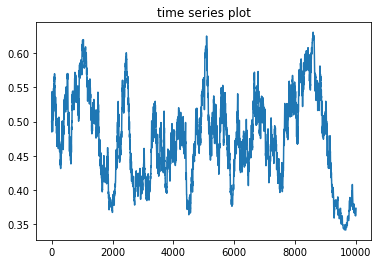

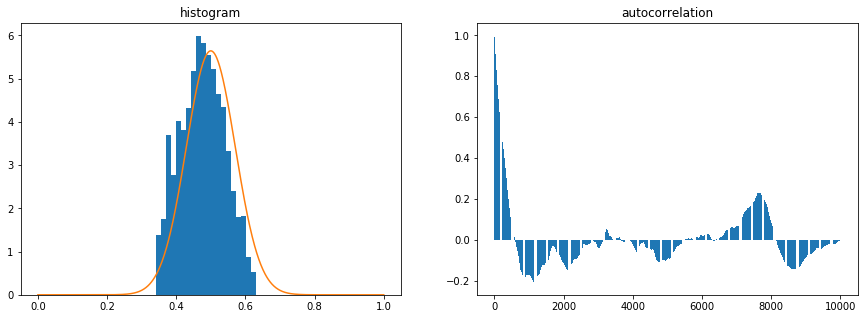

In [187]:
# example: local proposal and uniform pdf metropolis, proposal area 1/5th as large
delta = .02
proposal_generator = lambda s: min(max(0, s-delta/2), 1-delta) + np.random.rand()*delta
proposal_pdf = lambda x, y: 1/delta
pdf = lambda x: np.exp(-(x-.5)**2/.01)
metrop_gauss02 = Metrop(.5, pdf, proposal_pdf, proposal_generator)

r = metrop_gauss02(10000)[::1]
plt.title("time series plot")
plt.plot(r)
plt.show()

plt.figure(figsize=(15, 5))

# plot histogram
plt.subplot(121)
plt.title("histogram")
_ = plt.hist(r, bins=20, normed=True)
x = np.linspace(0, 1, 1000)
plt.plot(x, pdf(x)/integrate.quad(pdf, 0, 1)[0])

# plot autocorrelation
plt.subplot(122)
plt.title("autocorrelation")
acov = auto_corr(r)
plot_bins(acov)
plt.show()

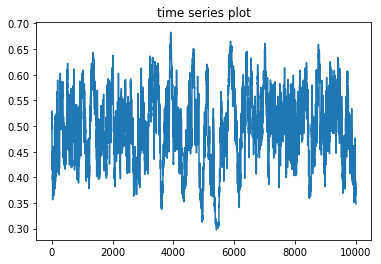

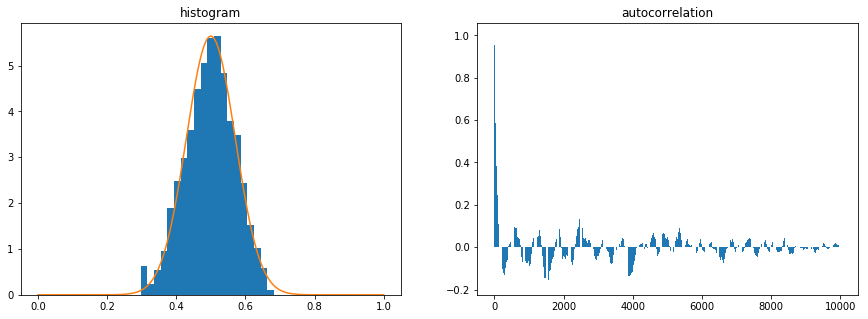

In [186]:
# example: local proposal and uniform pdf metropolis, proposal area 1/5th as large, now 10 times as many samples, subsample
delta = .02
proposal_generator = lambda s: min(max(0, s-delta/2), 1-delta) + np.random.rand()*delta
proposal_pdf = lambda x, y: 1/delta
pdf = lambda x: np.exp(-(x-.5)**2/.01)
metrop_gauss02 = Metrop(.5, pdf, proposal_pdf, proposal_generator)

r = metrop_gauss02(100000)[::10]
plt.title("time series plot")
plt.plot(r)
plt.show()

plt.figure(figsize=(15, 5))

# plot histogram
plt.subplot(121)
plt.title("histogram")
_ = plt.hist(r, bins=20, normed=True)
x = np.linspace(0, 1, 1000)
plt.plot(x, pdf(x)/integrate.quad(pdf, 0, 1)[0])

# plot autocorrelation
plt.subplot(122)
plt.title("autocorrelation")
acov = auto_corr(r)
plot_bins(acov)
plt.show()

In [11]:
class MCMC(object):
    def __init__(self, batch_length, generator):
        self.batch_length = batch_length
        self.generator = generator
        
    def sample_function(self, fn, batch_count):
        batch_means = np.empty(batch_count)
        for i in range(batch_count):
            fn_values = fn(self.generator(self.batch_length))
            # CLT: batch_mean is distributed according to normal(actual mean, batch_vars/batch_length) 
            # (if MC is reversible, stationary)
            batch_means[i] = np.mean(fn_values)
        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        plt.title("batch means")
        plt.plot(batch_means, "o")
        plt.xlabel("N")
        plt.subplot(122)
        plt.title("ACF of batch means")
        plot_bins(auto_corr(batch_means))
        plt.xlabel("N")
        plt.show()
        
        return batch_means
    
    def __call__(self, fn, N):
        assert N > self.batch_length, "N must be at least the size of a batch"
        batch_count = N // self.batch_length
        N = batch_count * self.batch_length
        
        batch_means = self.sample_function(fn, batch_count)
        mean = np.mean(batch_means)  # same as fn(chain) / N, since batch_count is constant throughout
        var_omc = np.mean((batch_means - mean)**2)  # estimates variance of fn / batch_length (i.e. variance of batch mean of fn)
        var_dependence = var_omc + 2 * np.mean(auto_cov(batch_means)[1:]) # this is probably not what we want
        
        # variance of the mean estimate is lag_cov(0) + 2 sum_k{ lag_cov(k) }
        # where lag_cov(k) is estimated by 1/m sum_i (batch_means_i - mean)(batch_means_{i+k} - mean)
        # ALTERNATIVELY: use smaller (thus better) convex minorant
        # this works because the sequence of batches is also a Markov chain and thus the CLT holds
        # i.e. here we estimate the mean batch value of fn, which (if the chain is stationary) is just the mean of fn
        return mean, np.sqrt(var_omc / batch_count), np.sqrt(var_dependence / batch_count)

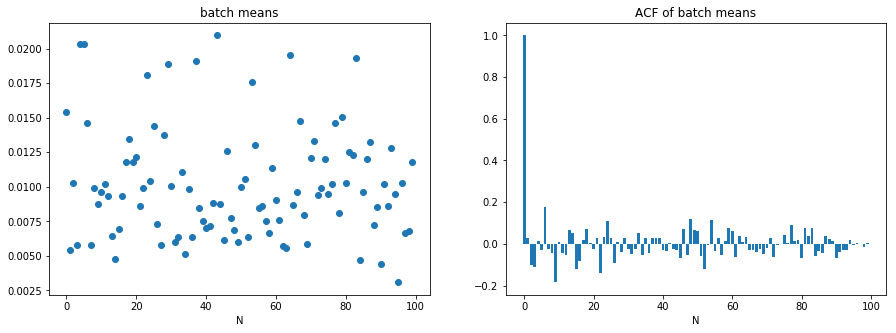

(0.010145125975439966, 0.00039629762766887075, 0.00039429104450881705)

In [25]:
delta = .05
proposal_generator = lambda s: min(max(0, s-delta/2), 1-delta) + np.random.rand()*delta
proposal_pdf = lambda x, y: 1/delta
pdf = lambda x: np.exp(-(x-.5)**2/(2*0.1**2))
metrop_gauss05 = Metrop(.2, pdf, proposal_pdf, proposal_generator)

mcmc = MCMC(1000, metrop_gauss05)
mcmc(lambda x: (x-.5)**2, 100000)